In [1]:
# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression,lars_path,LassoCV,RidgeCV, ElasticNet
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, max_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor

In [2]:
def choose_csv():
    '''
    Returns the dataset you chose. 

    '''
    data_counts = pd.read_csv('data/listings_cleaned_with_counts.csv', index_col=['id'])
    
    
    #data_all = data_all.loc[data_counts.index]
    
    data_raw = pd.read_csv('data/listings_cleaned.csv',index_col=['id'])
    
    return data_counts, data_raw

In [3]:
def cat_cols(data):
    data_all = pd.read_csv('data/listings.csv',index_col=['id'])
    
    cols = ['neighbourhood_cleansed','property_type','room_type','bed_type','cancellation_policy']
    data_all_temp = data_all.loc[data.index]
    cat_cols = data_all_temp[cols]
    
    threshold_percent = 10
    series = pd.value_counts(cat_cols['property_type'])
    mask = (series / series.sum() * 100).lt(threshold_percent)
    cat_cols = cat_cols.assign(property_type = np.where(cat_cols['property_type'].isin(series[mask].index),'Other', cat_cols['property_type']))
    
    data_cat = pd.concat([data, cat_cols], axis=1)
    data_cat = pd.get_dummies(data_cat)
    data_cat.columns = data_cat.columns.str.replace(' ','_')
    
    data_cat = data_cat.drop(columns = ['latitude','longitude'])
    return data_cat

In [4]:
def drop():
    data_counts, data_raw = choose_csv()
    
    if input('Do you want to drop columns? (y/n)') == 'y':
        print(list(data_counts))
        to_drop = []
        to_drop.append(input('Enter Column Name: '))
        while input('Do you want to drop more columns? (y/n)  ') == 'y':
            to_drop.append(input('Enter Column Name: '))
        data_counts = data_counts.drop(columns = to_drop)   
    
    #missing = input('How do you want to handle the missing data? (drop/0s) : ')
    data_counts = data_counts.dropna()
#     elif missing == '0s':
# #    elif:
#         data_counts = data_counts.fillna(0)
#     else:
#         from sklearn.experimental import enable_iterative_imputer
#         from sklearn.impute import IterativeImputer
#         imp = IterativeImputer(max_iter=10, random_state=0, tol=0.01)
#         data_for_modeling_imp = imp.fit_transform(data_for_modeling)
#         data_for_modeling = pd.DataFrame(data_for_modeling_imp, columns = data_for_modeling.columns)
        
    if input('Do you want to include categorical data? (y/n) : ') == 'y':
        data_for_modeling = cat_cols(data_counts)
        data_raw = cat_cols(data_raw)    
        
#         cols = ['neighbourhood_cleansed','property_type','room_type','bed_type','cancellation_policy']
#         data_counts_all = data_all.loc[data_counts.index]
#         cat_cols_counts = data_counts_all[cols]
        
        
        
        
#         cat_cols = data_all[cols]
        
#         print(len(cat_cols) == len(data_for_modeling))
        
#         threshold_percent = 10
#         series = pd.value_counts(cat_cols['property_type'])
#         mask = (series / series.sum() * 100).lt(threshold_percent)
#         cat_cols = cat_cols.assign(property_type = np.where(cat_cols['property_type'].isin(series[mask].index),'Other', cat_cols['property_type']))
        
#         data_for_modeling = pd.concat([data_counts, cat_cols], axis=1)
#         data_for_modeling = pd.get_dummies(data_for_modeling)
#         data_for_modeling.columns = data_for_modeling.columns.str.replace(' ','_')    
    else: 
        data_for_modeling = data_counts
        
#     if input("Do you want to drop the columns permanently? (y/n) ") == 'y':
#             data_raw.to_csv('data/listings_cleaned.csv')
    
    return data_for_modeling, data_counts, data_raw

In [5]:
def linreg(X_train, X_test, y_train, y_test):
    lin_reg = LinearRegression()  
    lin_reg.fit(X_train, y_train)
    y_train_pred = lin_reg.predict(X_train)
    y_test_pred = lin_reg.predict(X_test)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("Linear Regression")
    print("\nTraining r2:", train_score) 
    print("Validation r2:", test_score)

In [6]:
def lasso(X_train, X_test, y_train, y_test):
    alphas = 10**np.linspace(-2,2,200)
    lasso = LassoCV(alphas=alphas,cv=10,tol=0.1).fit(X_train, y_train)
    y_train_pred = lasso.predict(X_train)
    y_test_pred = lasso.predict(X_test)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("Lasso Regression")
    print("\nTraining r2:", train_score)
    print("Validation r2:", test_score)

In [7]:
def ridge(X_train, X_test, y_train, y_test):
    alphas = np.linspace(0,2,100)
    ridge = RidgeCV(normalize=False,alphas=alphas,cv=10).fit(X_train, y_train) 
    y_train_pred = ridge.predict(X_train)
    y_test_pred = ridge.predict(X_test)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("Ridge Regression")
    print("\nTraining r2:", train_score)
    print("Validation r2:", test_score)

In [8]:
def poly_lasso(X_train, X_test, y_train, y_test):
    poly = PolynomialFeatures(degree=2).fit(X_train)
    X_train_poly = poly.transform(X_train) 
    X_test_poly = poly.transform(X_test)
    alphas = 10**np.linspace(-2,2,100)
    lasso = LassoCV(alphas=alphas,cv=5,tol=0.5).fit(X_train_poly, y_train.ravel()) 
    y_train_pred = lasso.predict(X_train_poly)
    y_test_pred = lasso.predict(X_test_poly)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("Lasso Regression with Polynomial Features")
    print("\nTraining r2:", train_score)
    print("Validation r2:", test_score)

In [9]:
def poly_ridge(X_train, X_test, y_train, y_test):
    poly = PolynomialFeatures(degree=2).fit(X_train)
    X_train_poly = poly.transform(X_train) 
    X_test_poly = poly.transform(X_test)
    alphas = 10**np.linspace(-2,2,100)
    ridge = RidgeCV(normalize=True,alphas=alphas,cv=5,).fit(X_train_poly, y_train.ravel()) 
    y_train_pred = ridge.predict(X_train_poly)
    y_test_pred = ridge.predict(X_test_poly)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("Ridge Regression with Polynomial Features")
    print("\nTraining r2:", train_score)
    print("Validation r2:", test_score)

In [10]:
def boost(X_train, X_test, y_train, y_test):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.15, max_depth = 4, booster='gbtree')
    xg_reg.fit(X_train,y_train)
    y_train_pred = xg_reg.predict(X_train)
    y_test_pred = xg_reg.predict(X_test)
    train_score = round(r2_score(y_train, y_train_pred),4)
    test_score = round(r2_score(y_test, y_test_pred),4)
    print("XGBoost")
    print("\nTraining r2:", train_score)
    print("Validation r2:", test_score)
    fig, ax = plt.subplots(figsize=(14, 8))
    plot_importance(xg_reg, ax=ax)
    #ax.figure.savefig('reports/images/1.png')
    #pyplot.show()

In [11]:
data_for_modeling, data, data_raw = drop()

Do you want to drop columns? (y/n) y


['latitude', 'longitude', 'accommodates', 'bathrooms', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', 'number_of_reviews', 'number_of_reviews_ltm', 'restaurants', 'bars', 'cafes', 'universities', 'cta', 'time_to_cta_minutes']


Enter Column Name:  restaurants
Do you want to drop more columns? (y/n)   y
Enter Column Name:  bars
Do you want to drop more columns? (y/n)   y
Enter Column Name:  cafes
Do you want to drop more columns? (y/n)   y
Enter Column Name:  universities
Do you want to drop more columns? (y/n)   n
Do you want to include categorical data? (y/n) :  n


## Data without new variables 


In [12]:
X = data_raw.drop('price', axis=1)
y = data_raw.price
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#ey_scaled = scaler.fit_transform(y.values.reshape(-1,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [13]:
linreg(X_train, X_test, y_train, y_test)

Linear Regression

Training r2: 0.3584
Validation r2: 0.3486


In [14]:
lasso(X_train, X_test, y_train, y_test)

Lasso Regression

Training r2: 0.3584
Validation r2: 0.3488


In [15]:
ridge(X_train, X_test, y_train, y_test)

Ridge Regression

Training r2: 0.3584
Validation r2: 0.3487


In [16]:
#poly_lasso(X_train, X_test, y_train, y_test)

Lasso Regression with Polynomial Features

Training r2: 0.3725
Validation r2: 0.3655


In [17]:
#poly_ridge(X_train, X_test, y_train, y_test)

Ridge Regression with Polynomial Features

Training r2: 0.3885
Validation r2: 0.3465


XGBoost

Training r2: 0.6446
Validation r2: 0.4855


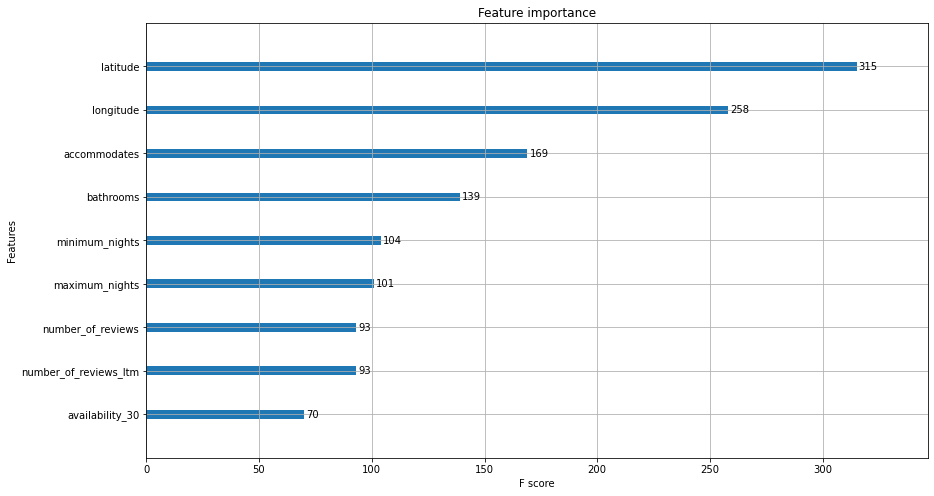

In [19]:
boost(X_train, X_test, y_train, y_test)

## Data with new variables 

In [ ]:
X = data_for_modeling.drop('price', axis=1)
y = data_for_modeling.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
linreg(X_train, X_test, y_train, y_test)

In [ ]:
lasso(X_train, X_test, y_train, y_test)

In [ ]:
ridge(X_train, X_test, y_train, y_test)

In [ ]:
poly_lasso(X_train, X_test, y_train, y_test)

In [ ]:
poly_ridge(X_train, X_test, y_train, y_test)

In [ ]:
boost(X_train, X_test, y_train, y_test)